# Assignment 3: Advanced Topics on Deep Learning
### Sinusoidal Representation Networks for Solving Bayesian Image Recovery
#### Centro de Investigación en Matemáticas, A.C.
#### Alejandro Daniel Lemus Najera
---

## Problem Formulation

Our starting point will be the following observation model:

$$
    g(x) = f(x) + \eta(x)
$$

for $x \in \mathcal{D} \subset \mathbb{Z}^2$. Here $g$ is our observed and corrupted image, $f$ is the original image we would like to recover and $\eta \sim \mathcal{N}(0, \sigma^2)$ is Gaussian noise. Here $\mathcal{D}$ is our discretized image domain. We also assume that all samples taken from our contaminating Gaussian distribution are i.i.d.

Here we will find an approximation to $f$ using a Sinusoidal Representation Network $f_{\theta}$ optimizing the following cost functions:

1. First order quadratic regularization loss

$$
    L(f_{\theta}) = ||{f_{\theta}  - g}||^2 +\lambda ||{\nabla f_{\theta}}||^2
$$

2. Robust regularization using total variation

$$
    L(f_{\theta}) = ||{f_{\theta}  - g}||^2 +\lambda ||{\nabla f_{\theta}}||
$$

Here, $\lambda$ is a hyperparameter balancing the importance of the regularization and data terms. We will use the ubiquitous cameraman image, apply Gaussian noise to it and see how both approaches perform on recovering the original image.

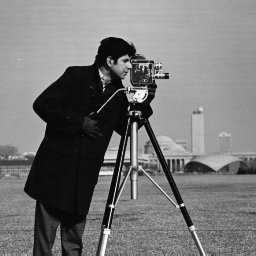

## Library Imports

In [1]:
import os
from typing import Any, Callable, List, Tuple

from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import  Resize, Compose, ToTensor, Normalize
from PIL import Image

from dataload import *
from loss import *
from models import *

/home/lemus/miniconda3/envs/nerf/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sine Layer and SIREN Model Definition

In [2]:
# SINE LAYER MODULE

class SineLayer(nn.Module):
    def __init__(
            self,
            in_features: int,
            out_features: int,
            bias: bool = True,
            is_first: bool = False,
            omega_0: float = 30.) -> None:
        r'''Sine layer initialization method.
        ----------------------------------------------------------------------- 
            Args:
                in_features: Number of input features
                out_features: Number of output features
                bias: If True, use bias parameters
                is_first: If False, divide weights by omega_0 frequency factor
                omega_0: Frequency factor to apply at the first layer
            Returns:
                None'''
        super().__init__()
        self.omega_0 = omega_0
        self.in_features = in_features
        self.is_first = is_first

        # Create linear layer
        self.linear = nn.Linear(in_features, out_features, bias)

        # Initialize weights
        self.__init_weights()


    def __init_weights(self) -> None:
        r'''Initialize layer weights according to initialization scheme proposed
        by authors.
        ------------------------------------------------------------------------ 
        Returns:
            None'''
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1. / self.in_features,
                                            1. / self.in_features)
            else:
                self.linear.weight.uniform_((-np.sqrt(6 / self.in_features) /
                                             self.omega_0),
                                            (np.sqrt(6 / self.in_features) /
                                             self.omega_0))


    def forward(
            self,
            input: torch.Tensor) -> torch.Tensor:
        r'''Forward pass through sine layer.
        ------------------------------------------------------------------------
        Args:
            input: (batch_size, self.in_features)-shape tensor
        Returns:
            (batch_size, out_features)-shape tensor''' 
        return torch.sin(self.omega_0 * self.linear(input))


    def forward_with_intermediate(
            self,
            input: torch.Tensor) -> Tuple[torch.Tensor, ...]: 
        r'''Forward pass through sine layer with intermediate activation info.
        ------------------------------------------------------------------------
        Args:
            input: (batch_size, self.in_features)-shape tensor
        Returns:
            (batch_size, out_features)-shape tensor
            intermediate: (batch_size, out_features)-shape tensor containing the
                          arguments to the sine activation function''' 
        intermediate = self.omega_0 * self.linear(input)

        return torch.sin(intermediate), intermediate


# SIREN (Sinusoidal Representation Network) MODULE

class Siren(nn.Module):
    def __init__(
            self,
            in_features: int,
            hidden_features: int,
            hidden_layers: int,
            out_features: int,
            outermost_linear: bool = False,
            first_omega_0: float = 30.,
            hidden_omega_0: float = 30.) -> None:
        r'''SIREN module initialization method.
        ----------------------------------------------------------------------- 
            Args:
                in_features: Number of input features
                hidden_features: Width of internal layers
                hidden_layers: Number of hidden layers
                out_features: Number of output features
                outermost_linear: If True, use linear activation at final layer
                first_omega_0: Omega_0 value to be used at first layer
                hidden_omega_0: Omega_0 value to be uset at hidden layers
            Returns:
                None'''
        super().__init__()

        self.net = [] # Ordered list containing model layers
        # Append first layer
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        # Append hidden layers
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        # Append last layer
        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            # Initialize weights accordingly
            with torch.no_grad():
                final_linear.weight.uniform_((-np.sqrt(6 / hidden_features) /
                                             hidden_omega_0),
                                            (np.sqrt(6 / hidden_features) /
                                             hidden_omega_0))
            
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        # Create sequential model from layers in net list
        self.net = nn.Sequential(*self.net)


    def forward(
            self, 
            coords: torch.Tensor) -> Tuple[torch.Tensor, ...]:
        r'''Forward pass method through SIREN module.
        -----------------------------------------------------------------------
        Args:
            coords: (batch_size, in_features)-shape tensor
        Returns:
            output: (batch_size, out_features)-shape tensor
            coords: Clone of original input tensor that requires gradient''' 
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)

        return output, coords


## Dataset Class Definition and Data Loading Utilities

In [3]:
# DATA LOADING UTILITIES 

def get_mgrid(sidelength: int, dim: int = 2) -> torch.Tensor:
    r'''Generates a flattened tensor that represents a grid of spatio-temporal
    coordinates (x, y, ...) within the normalized range of (-1, 1).
    ---------------------------------------------------------------------------
    Args:
        sidelength: Image sidelenght. It is assumed that image is square.
        dim: Number of dimension for spatio-temporal coordinates.
    Returns:
        mgrid: (SxS, dim)-shape tensor containing flattened spatio-temporal
               coordinates.'''
    # Create tuple of (1,)-shape tensors for each dimension
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelength)])
    # Create meshgrid from tuple of tensor
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    # Flatten meshgrid
    mgrid = mgrid.reshape(-1, dim)

    return mgrid


def get_image_tensor(
        img_path: str,
        sidelength: int = 256) -> torch.Tensor:
    r'''Opens image from file path, applies transformations and returns it as a
    tensor.
    --------------------------------------------------------------------------- 
    Args:
        img_path: file location.
        sidelength: Square dimension. Image dims are resized to be equal.
    Returns:
        img: (S, S, N)-shape tensor. S stands for sidelenght parameter.'''
    # Open file 
    img = Image.open(img_path) 
    # Compose and apply transforms
    n_channels = 1 if img.mode == 'L' else 3
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(0.5 * torch.ones(n_channels), 0.5 * torch.ones(n_channels))
    ])
    img = transform(img)

    return img


# IMAGE DATASET

class ImageDataset(Dataset):
    r'''Dataset consisting of image coordinates (x, y) and their corresponding
    intensity values f(x, y) for grayscale images and RGB values (r, g, b) for
    color images.'''
    def __init__(
            self,
            img_path: str,
            sidelength: int = 256) -> None:
        r'''Dataset initialization method.
        -----------------------------------------------------------------------
        Args:
            img_path: file location.
            sidelength: Square dimension. Image dims are resized to be equal.
        Returns:
            None'''
        # Base class init method call
        super().__init__()

        # Get image as tensor
        img = get_image_tensor(img_path, sidelength=sidelength)
        self.n_channels = img.shape[0]
        self.pixels = img.permute(1, 2, 0).view(-1, self.n_channels) 

        # Noisy image is saved as a copy of pixels
        self.noisy = torch.clone(self.pixels)

        # Get flattened grid of coordinates
        self.coords = get_mgrid(sidelength, 2)


    def __len__(self):
        r'''Internal method to retrieve length of the dataset.
        -----------------------------------------------------------------------
        Returns:
            number of training samples.'''

        return self.pixels.shape[0]


    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, ...]:
        r'''Internal method to acces randomly to an element of the dataset
        according to an index parameter.
        -----------------------------------------------------------------------
        Args:
            idx: Element index of interest.
        Returns:
            Tuple of tensors containing element coords and pixel values.'''
        
        return self.coords[idx], self.noisy[idx]


    def apply_noise(self, sigma: float) -> None:
        r'''Applies Gaussian noise to the original image.
        -----------------------------------------------------------------------
        Args:
            sigma: Standard deviation of Gaussian distribution.
        Returns:
            None''' 
        self.noisy = self.pixels + torch.normal(0., sigma, self.pixels.shape)

## Gradient Calculation

In [4]:
# GRADIENT UTILITIES

def gradient(
        y: torch.Tensor, 
        x: torch.Tensor, 
        grad_outputs: torch.Tensor = None) -> torch.Tensor:
    r'''Computes gradient of tensor y with respect to tensor x.
    ---------------------------------------------------------------------------
    Args:
        y: output tensor.
        x: input tensor.
        grad_outputs: precomputed gradients w.r.t. each of the outputs.
    Returns:
        grad: gradient of y w.r.t. input x.'''
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)

    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs,
                               create_graph=True)
    grad = grad[0]

    return grad

## Loss Functions using Quadratic and Total Variation Regularizers

In [5]:
# LOSS UTILITIES

def mse_loss(
        model_output: torch.Tensor, 
        coords: torch.Tensor,
        ground_truth: torch.Tensor,
        lambda_: float = .1) -> torch.Tensor:
    r'''Computes first order quadratic regularization loss function.
    ---------------------------------------------------------------------------
    Args:
        model_output: (batch_size, n_channels)-shape tensor.
        ground_truth: (batch_size, n_channels)-shape tensor.
        coords: (batch_size, input_dim)-shape tensor.
        lambda_: Regularization factor.
    Returns:
        loss: (1,)-shape tensor holding loss term scalar value.'''
    # Compute data fidelity term
    loss = ((model_output - ground_truth)**2).mean()
    # Compute gradients on the model outputs
    grads = gradient(model_output, coords) 
    # Compute and add gradient loss
    loss += lambda_ * torch.mean((grads**2).sum(-1))

    return loss

def tv_loss(
        model_output: torch.Tensor,
        coords: torch.Tensor,
        ground_truth: torch.Tensor,
        lambda_: float = .1) -> torch.Tensor:
    r'''Computes total variation regularization loss function.
    ---------------------------------------------------------------------------
    Args:
        model_output: (batch_size, n_channels)-shape tensor.
        ground_truth: (batch_size, n_channels)-shape tensor.
        coords: (batch_size, input_dim)-shape tensor.
        lambda_: Regularization factor.
    Returns:
        loss: (1,)-shape tensor holding loss term scalar value.'''
    # Compute data fidelity term
    loss = ((model_output - ground_truth)**2).mean()
    # Compute gradients on the model outputs
    grads = gradient(model_output, coords)
    # Compute and add TV loss
    loss += lambda_ * torch.mean(torch.abs(grads).sum(-1))

    return loss


## Training Loop

In [6]:
# TRAINING LOOP

def train(
        dataset,
        model,
        loss_fn: Callable,
        out_dir: str,
        sigma: float = 0.,
        lambda_: float = 0.1,
        lrate: float = 1e-4,
        total_steps: int = 500,
        steps_til_summary: int = 50) -> Tuple[float, torch.Tensor, torch.Tensor]:
    r'''Training loop to fit an image using Siren model. This function uses ADAM
    optimizer with all the default parameters except for learning rate. It also
    assumes the whole image as the batch size
    ---------------------------------------------------------------------------
    Args:
        dataset: Image dataset with ground truth pixel values and coordinates.
        model: Siren model to be optimized.
        loss_fn: Loss function to be used during optimization.
        out_dir: Path to store results.
        sigma: Standard deviation for Gaussian noise distribution.
        lambda_: Hyperparameter balancing regularization term.
        lrate: Learning rate.
        total_steps: Total number of iterations.
        steps_til_summary: Display rate for optimization procedure.
    Returns:
        loss_vals: (total_steps)-length list containing loss values during 
                   training process.
        otuput: (sidelenght, sidelength, 1)-shape numpy array 
                containing model output after total_steps.
        grads: (sidelength, sidelength, 1)-shape numpy array containing
               output gradient norm after total_steps.'''
    # Create folder to store results
    try:
        os.makedirs(os.path.join(f'out/{out_dir}/'))
    except:
        pass

    # Apply noise to original image in dataset
    dataset.apply_noise(sigma)

    # Create ADAM optimizer instance
    optimizer = torch.optim.Adam(lr=lrate, params=model.parameters())

    # Create DataLoader instance
    dataloader = DataLoader(dataset, batch_size=len(dataset),
                            pin_memory=True, num_workers=0)

    # Retrieve whole dataset
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = (model_input[None, ...].cuda('cuda:1'),
            ground_truth[None, ...].cuda('cuda:1'))

    # Initialize list to hold loss values
    loss_vals = []
    
    for step in range(total_steps):
        # Compute model outputs
        model_output, coords = model(model_input)
        # Compute loss
        loss = loss_fn(model_output, coords,  ground_truth, lambda_)
        # Save loss
        loss_vals.append(loss.item())
        # Display optimization process info
        if not step % steps_til_summary:
            print("Step %d, Total loss %0.6f" % (step, loss))
            img_grad = gradient(model_output, coords)

            # Prepare model output and gradients for display
            output = model_output.cpu().view(256, 256).detach().numpy()
            grads = img_grad.norm(dim=-1).cpu().view(256, 256).detach().numpy()

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            axes[0].imshow(ground_truth.cpu().view(256, 256).detach().numpy(),
                           cmap='gray')
            axes[0].set_title('Original')
            axes[1].imshow(output, cmap='gray')
            axes[1].set_title(f'Model output: Iteration {step}')
            axes[2].imshow(grads, cmap='gray')
            axes[2].set_title(f'Output gradient: Iteration {step}')
            plt.savefig(f'out/{out_dir}/iteration_{step}.png')
            plt.show()
            plt.close()

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_vals, output, grads

## Hyperparameters Selection

In [7]:
# HYPERPARAMETERS

filepath = 'data/cameraman.png'
total_steps = 500
steps_til_summary = 10
lrate = 1e-4

## Dataset and Model Instantiation

In [8]:
# Instantiate dataset and SIREN model
cameraman = ImageDataset(filepath)
siren = Siren(in_features=2, out_features=1, hidden_features=256,
              hidden_layers=3, outermost_linear=True)
# Send to GPU
siren.cuda('cuda:1')

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Case Study: $\sigma=0.2$

### a. Using Quadratic Regularization

Step 0, Total loss 0.279666


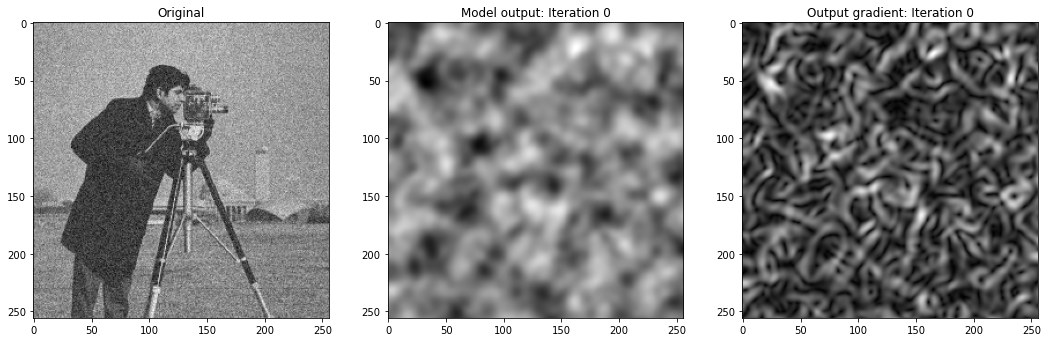

Step 50, Total loss 0.085444


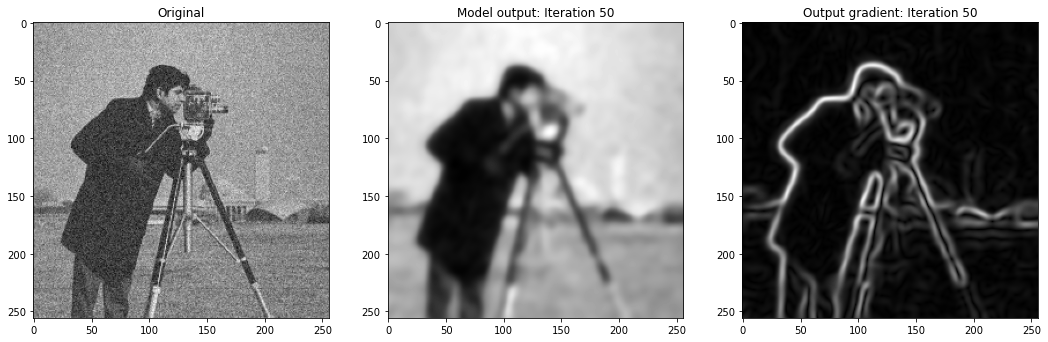

Step 100, Total loss 0.084349


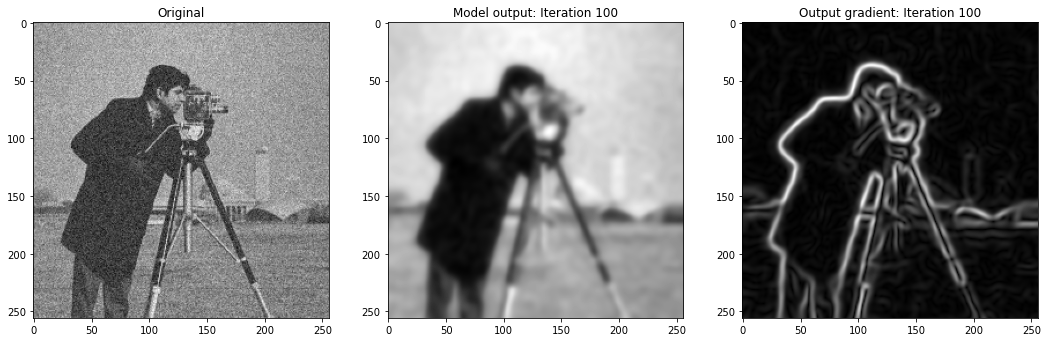

Step 150, Total loss 0.083938


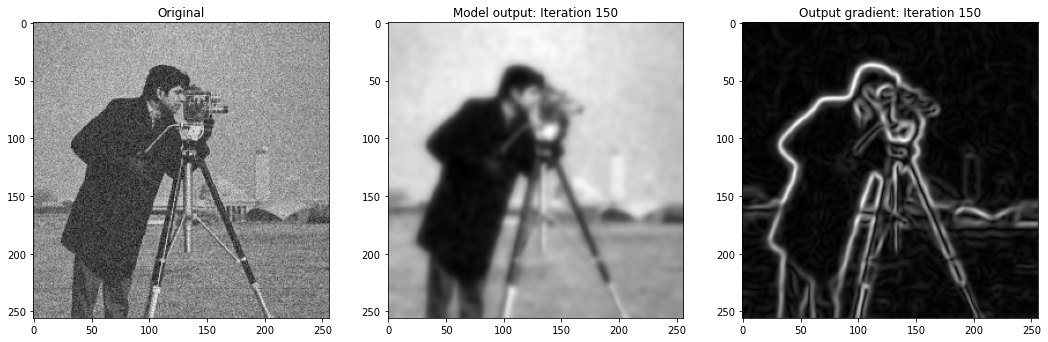

Step 200, Total loss 0.083715


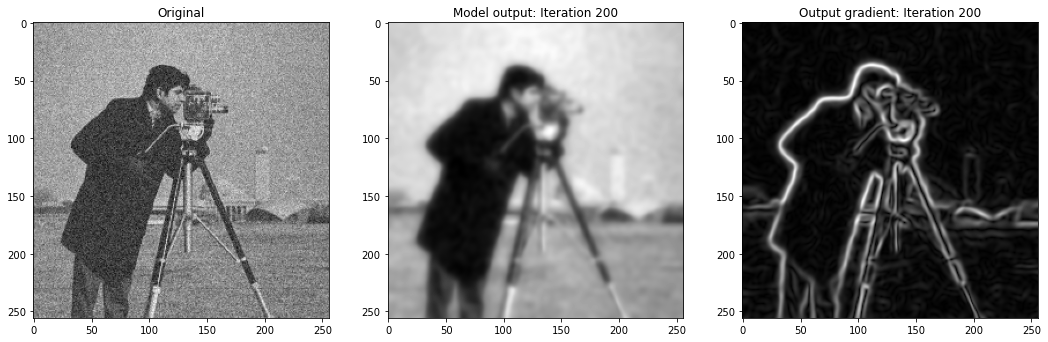

Step 250, Total loss 0.083560


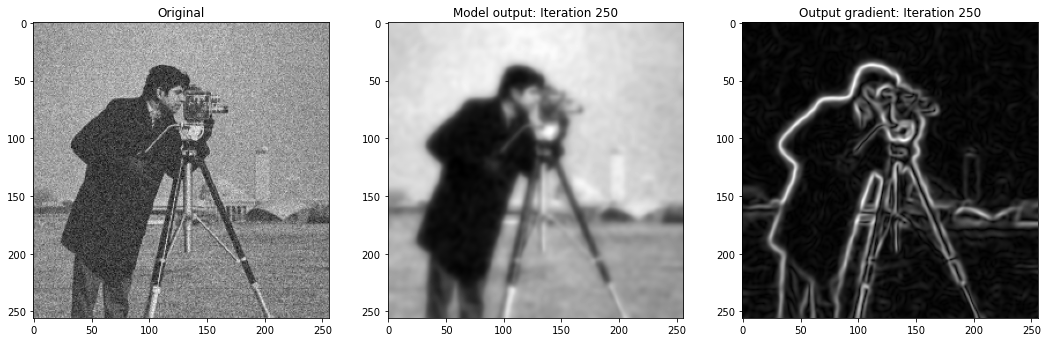

Step 300, Total loss 0.083437


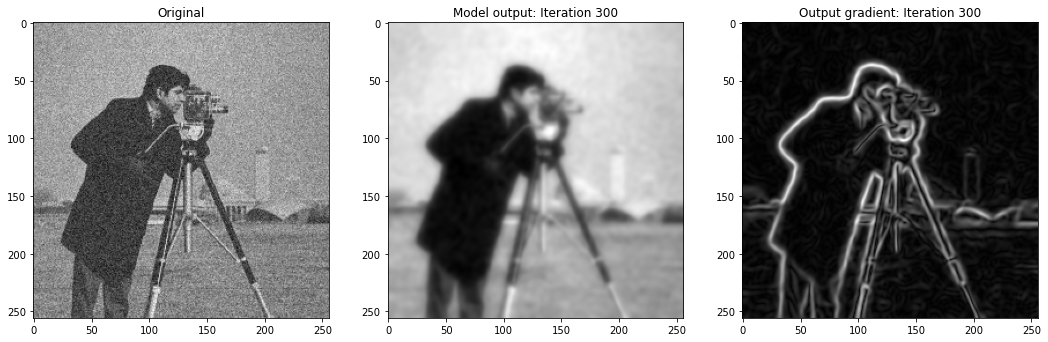

Step 350, Total loss 0.083335


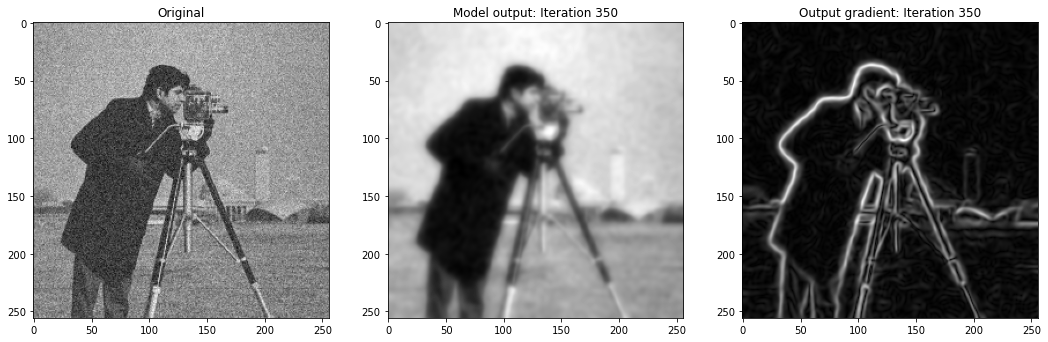

Step 400, Total loss 0.083249


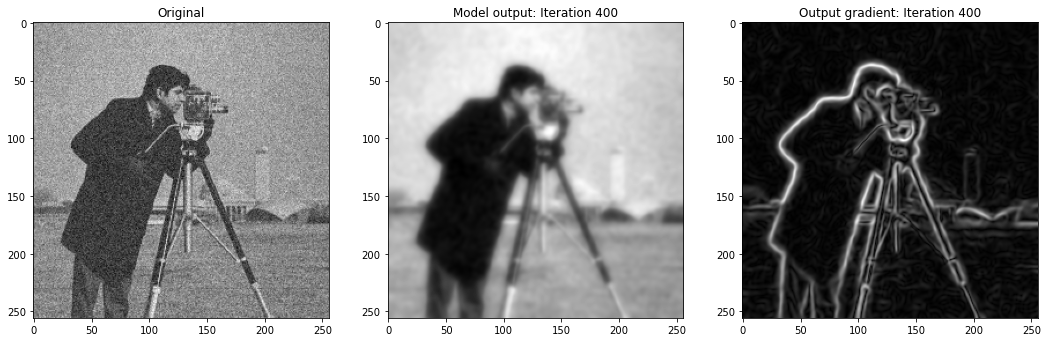

Step 450, Total loss 0.083177


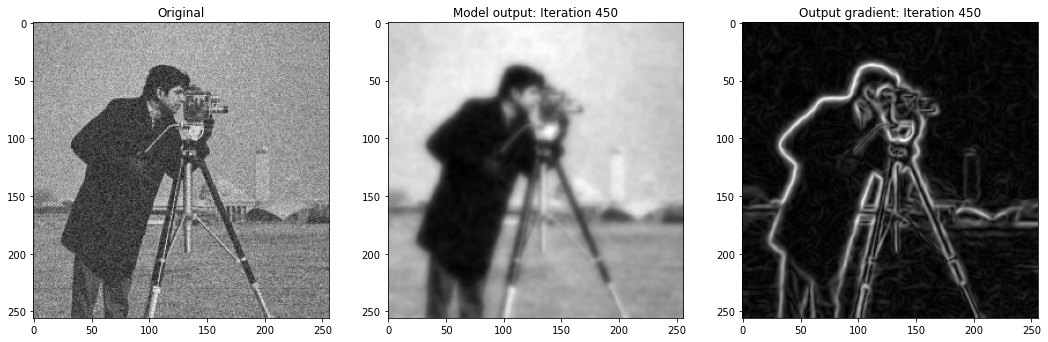

In [9]:
# Fit SIREN using MSE loss
mse_vals, mse_out, mse_grads = train(dataset=cameraman, model=siren,
                               loss_fn=mse_loss, out_dir='MSE',
                               lambda_=5e-4, sigma=0.2)

### b. Using Total Variation Regularization

Step 0, Total loss 0.090567


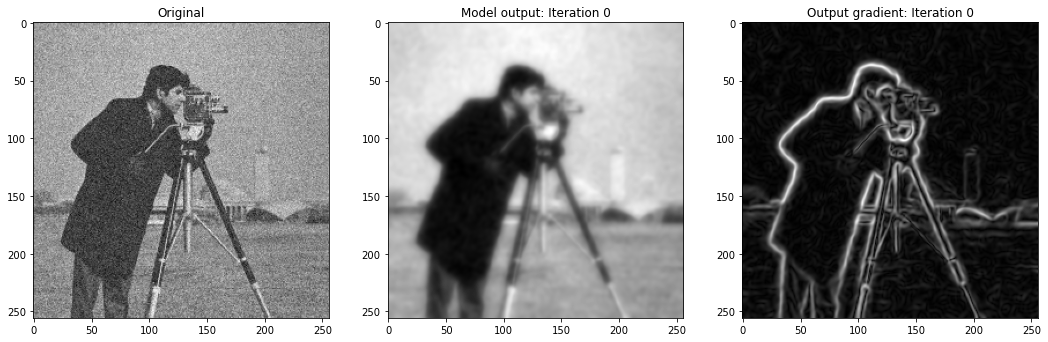

Step 50, Total loss 0.077172


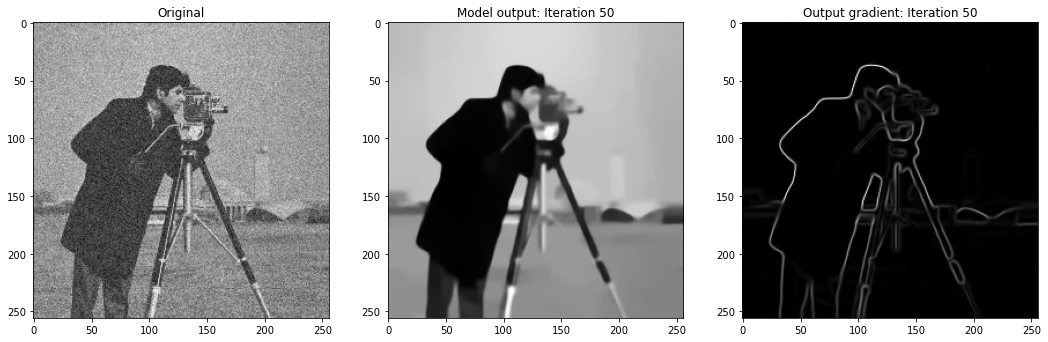

Step 100, Total loss 0.075590


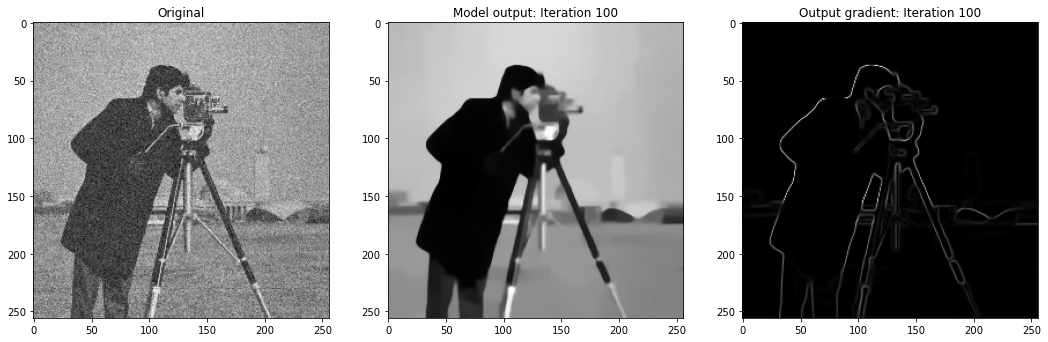

Step 150, Total loss 0.074999


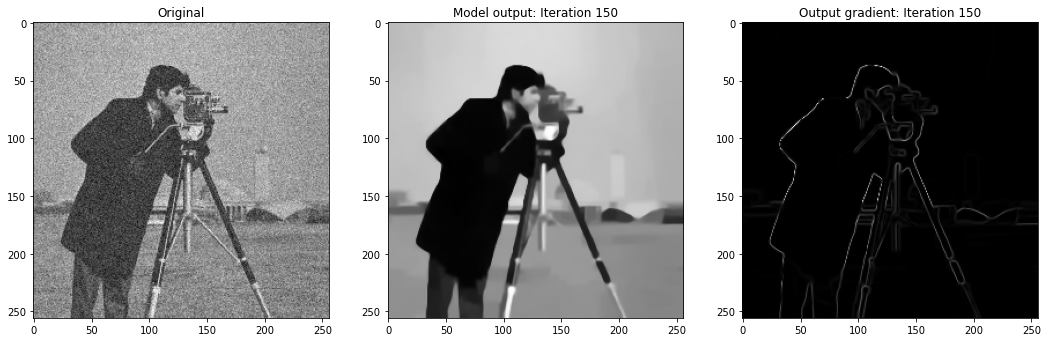

Step 200, Total loss 0.074519


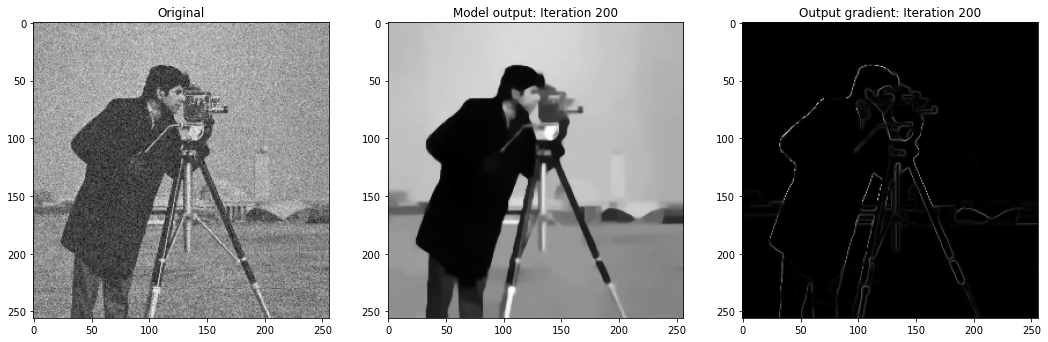

Step 250, Total loss 0.073451


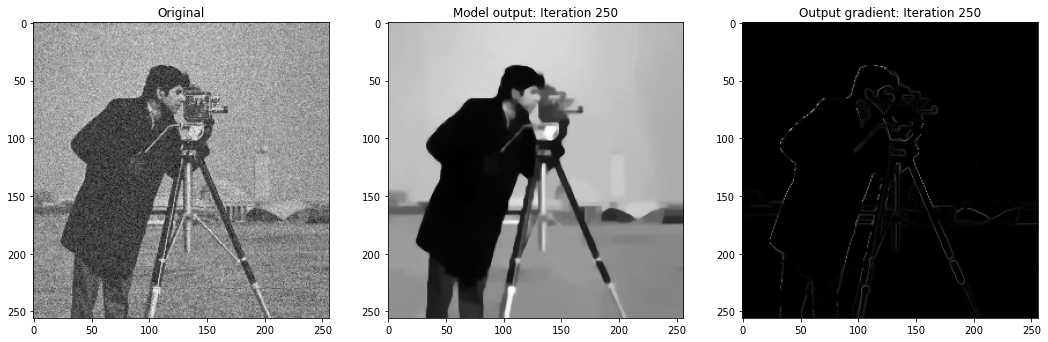

Step 300, Total loss 0.072186


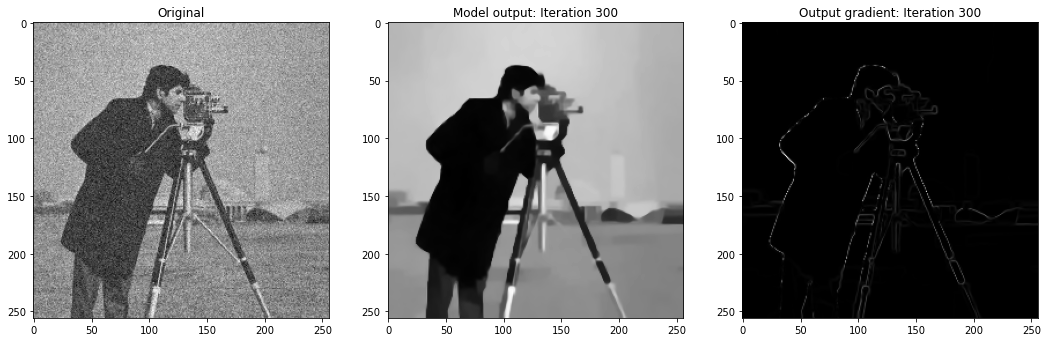

Step 350, Total loss 0.070727


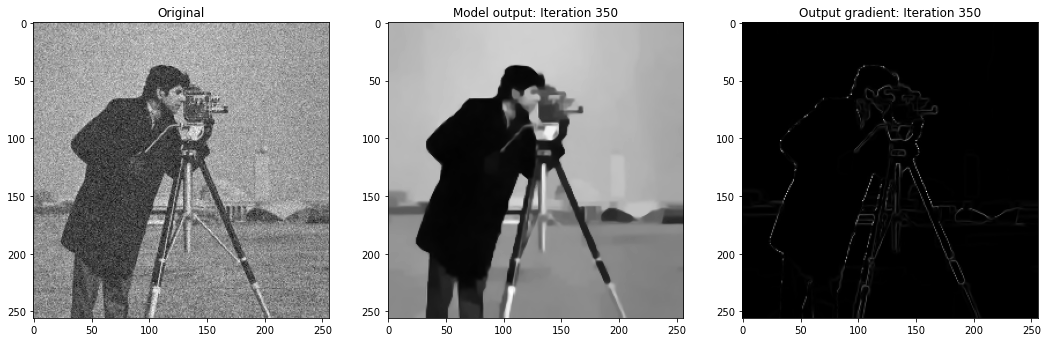

Step 400, Total loss 0.069872


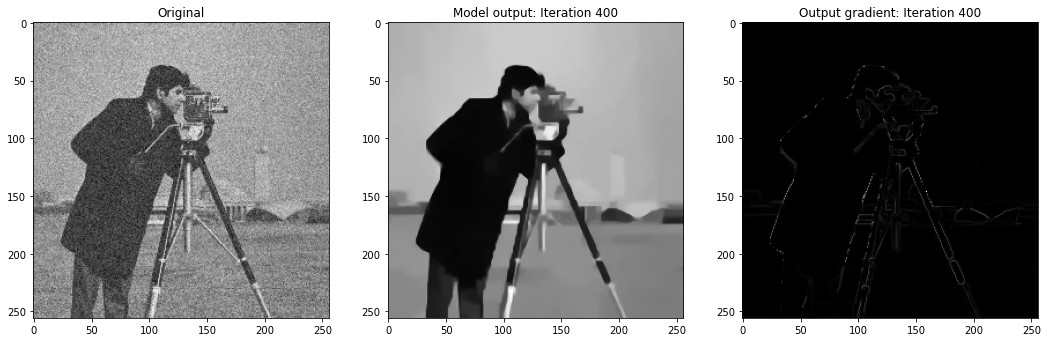

Step 450, Total loss 0.068818


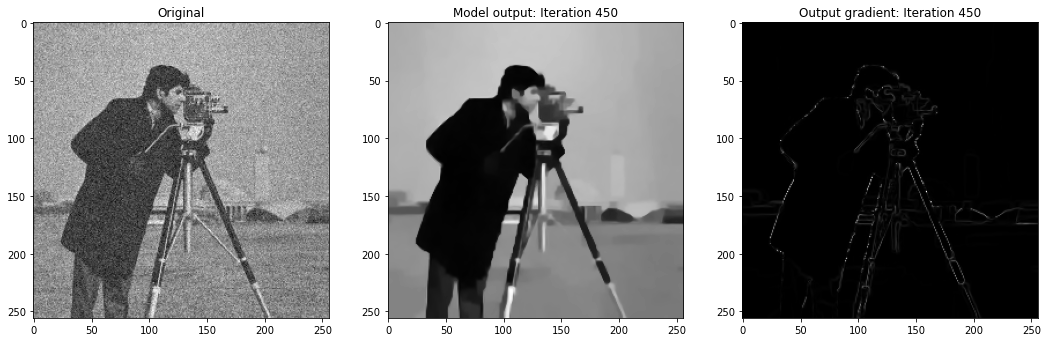

In [10]:
# Fit SIREN usin TV loss
tv_vals, tv_out, tv_grads = train(dataset=cameraman, model=siren,
                            loss_fn=tv_loss, out_dir='TV',
                            lambda_=5e-3, sigma=0.2)

### c. Final Results

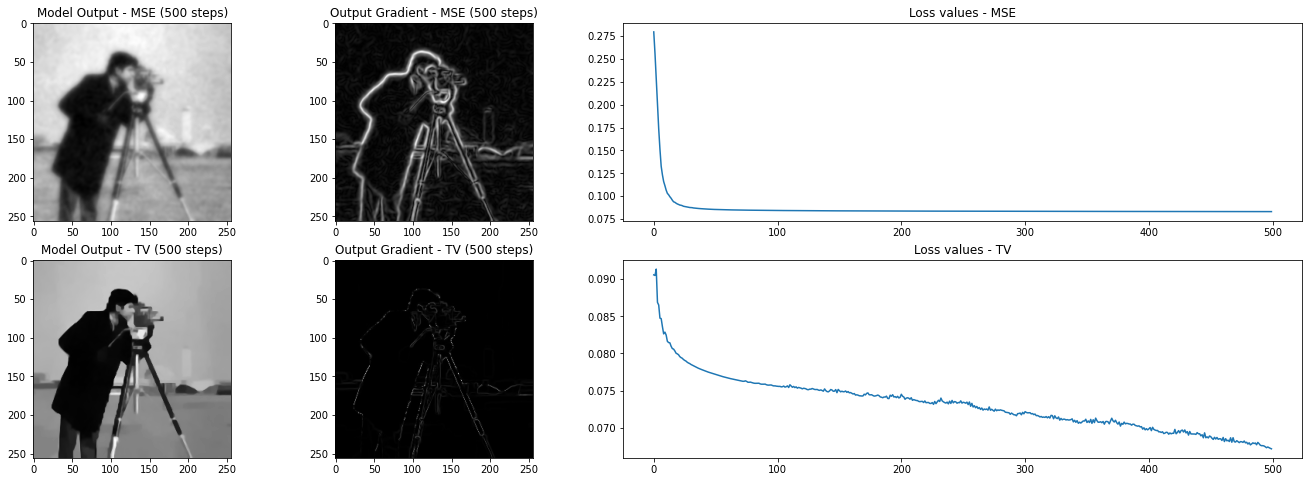

In [11]:
# Plot final results
fig, axes = plt.subplots(2, 3, figsize=(23, 8),
                         gridspec_kw={'width_ratios': [1, 1, 3]})
axes[0,0].imshow(mse_out, cmap='gray')
axes[0,0].set_title('Model Output - MSE (500 steps)')

axes[0,1].imshow(mse_grads, cmap='gray')
axes[0,1].set_title('Output Gradient - MSE (500 steps)')

axes[0,2].plot(mse_vals)
axes[0,2].set_title('Loss values - MSE')

axes[1,0].imshow(tv_out, cmap='gray')
axes[1,0].set_title('Model Output - TV (500 steps)')

axes[1,1].imshow(tv_grads, cmap='gray')
axes[1,1].set_title('Output Gradient - TV (500 steps)')

axes[1,2].plot(tv_vals)
axes[1,2].set_title('Loss values - TV')

plt.savefig('out/results.png')
plt.show()
plt.close()

## Conclusion

As we can observe from our case study, quadratic regularization recovers a blurry image, this is due to the fact that L2 regularization is more influenced by outliers than L1 norm. The influence function for L2 norm is proportional to its argument. Here we can see that in this case edges are not preserved that well and there are still small local variations present in our recovered image.

In contrast, we see a recovered image with sharper edges for the total variation regularization, this regularization tends to produce a sparser gradient map, where high discontinuities do not have much influence on the optimization process and small local variations are oversmoothed.

We also observe that the first regularization converges more rapidly to a solution, in comparison to the second regularization where the loss.